# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [98]:
import os
import re
import emoji
import pandas as pd
import numpy as np
import json
import nltk
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

sw = stopwords.words("english")

In [34]:
# change `data_location` to the location of the folder on your machine.
data_location = "/users/kayan/Desktop/M1_Results/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [35]:
# Read in the lyrics data
lyrics_folder_path = os.path.join(data_location, lyrics_folder)

# List all subfolders in the "lyrics" folder
artist_folders = [f for f in os.listdir(lyrics_folder_path) if os.path.isdir
                  (os.path.join(lyrics_folder_path, f))]

# Create an empty list to store the content of each file
lyrics_data = []

# Iterate over each artist folder
for artist_folder in artist_folders:
    artist_folder_path = os.path.join(lyrics_folder_path, artist_folder)
    
    # List all text files in the current artist folder
    text_files = [f for f in os.listdir(artist_folder_path) if f.endswith('.txt')]

    # Iterate over each text file in the current artist folder
    for text_file in text_files:
        file_path = os.path.join(artist_folder_path, text_file)
        
        with open(file_path, 'r', encoding='utf-8') as file:
            content = file.read()
            lyrics_data.append({'artist': artist_folder, 'file_name': text_file,
                                'content': content})

In [36]:
# Read in the twitter data

twitter_folder_path = os.path.join(data_location, 'twitter')

# List of specific files to extract descriptions from
artist_files = ['cher_followers_data.txt', 'robynkonichiwa_followers_data.txt']

# Initialize an empty list to store dictionaries for each artist
twitter_data = []

# Iterate over the specified files
for artist_file in artist_files:
    file_path = os.path.join(twitter_folder_path, artist_file)

    if os.path.exists(file_path):
        with open(file_path, 'r', encoding='utf-8') as file:
            # Read the lines from the file
            lines = file.readlines()

            descriptions = [line.split('\t')[6].strip() for line in lines[1:]] 

            # Store the descriptions in the dictionary with the artist as the key
            artist_name = artist_file.split('_')[0]
            twitter_data.append({'artist': artist_name, 'descriptions': descriptions})


In [40]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
# Define the file paths
positive_words_path = os.path.join(data_location, positive_words_file)
negative_words_path = os.path.join(data_location, negative_words_file)
tidytext_sentiment_path = os.path.join(data_location, tidy_text_file)

def read_sentiment_file(file_path, sentiment_score):
    with open(file_path, 'r', encoding='latin-1') as file:
        words = file.read().splitlines()
        return {word: sentiment_score for word in words}

# Read positive words with a score of +1
positive_words_dict = read_sentiment_file(positive_words_path, 1)

# Read negative words with a score of -1
negative_words_dict = read_sentiment_file(negative_words_path, -1)

# Read tidytext sentiment file and create a dictionary
tidytext_sentiment_dict = {}
with open(tidytext_sentiment_path, 'r', encoding='latin-1') as file:
    for line in file:
        elements = line.strip().split("\t")

        # Skip lines that cannot be converted to an integer
        if len(elements) >= 2 and elements[1].isdigit():
            word = elements[0]
            score = int(elements[1])
            tidytext_sentiment_dict[word] = score


## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [51]:
# your code here
def calculate_sentiment(words):
    sentiment_score = 0
    for word in words:
        if word in positive_words_dict:
            sentiment_score += positive_words_dict[word]
        elif word in negative_words_dict:
            sentiment_score += negative_words_dict[word]
        elif word in tidytext_sentiment_dict:
            sentiment_score += tidytext_sentiment_dict[word]
    return sentiment_score

# Create a list to store the sentiment scores
sentiment_scores = []

# Iterate over songs and calculate sentiment
for song_info in lyrics_data:
    artist = song_info['artist']
    file_name = song_info['file_name']
    lyrics = song_info['content']

    # Tokenize lyrics into words (you might need more advanced tokenization)
    words = nltk.word_tokenize(lyrics)

    # Calculate sentiment score
    song_sentiment = calculate_sentiment(words)

    # Store the results
    sentiment_scores.append({'artist': artist, 'song': file_name, 
                             'sentiment': song_sentiment})

# Create a DataFrame from the results
sentiment_df = pd.DataFrame(sentiment_scores)

# Display the resulting DataFrame
print(sentiment_df)

    artist                        song  sentiment
0    robyn      robyn_includemeout.txt         -4
1    robyn          robyn_electric.txt        -10
2    robyn         robyn_beach2k20.txt         20
3    robyn         robyn_lovekills.txt        -31
4    robyn       robyn_timemachine.txt         -3
..     ...                         ...        ...
415   cher  cher_takeitfromtheboys.txt         10
416   cher          cher_dreambaby.txt         11
417   cher   cher_pleasedonttellme.txt         -1
418   cher     cher_ihopeyoufindit.txt          1
419   cher       cher_classified1a.txt          3

[420 rows x 3 columns]


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: 
Cher has the higher average sentiment per song with 2.40.
The average sentiment per song for cher is 2.40
The average sentiment per song for robyn is 1.35

---

In [52]:
#Overall, which artist has the higher average sentiment per song?
average_sentiments = sentiment_df.groupby('artist')['sentiment'].mean()

# Print the average sentiment for each artist
for artist, avg_sentiment in average_sentiments.items():
    print(f"The average sentiment per song for {artist} is {avg_sentiment:.2f}")

The average sentiment per song for cher is 2.40
The average sentiment per song for robyn is 1.35


Q: For your first artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

the lyrics or the song's title contains the positive words or negactive words

robyn's Top 3 Songs with the Highest Sentiments:

                        song  sentiment
21      robyn_loveisfree.txt         67

73  robyn_indestructible.txt         27

45   robyn_buffalostance.txt         24

robyn's Bottom 3 Songs with the Lowest Sentiments:

                        song  sentiment
                                         
53        robyn_dontfuckingtellmewhattodo.txt        -78

75  robyn_dontfuckingtellmewhattodo114520.txt        -78

16                   robyn_criminalintent.txt        -46

---

In [75]:
# Find the top 3 songs with the highest sentiment scores for robyn
robyn_sentiments = sentiment_df[sentiment_df['artist'] == 'robyn']
robyn_top3_highest_sentiments = robyn_sentiments.nlargest(3, 'sentiment')

print("robyn's Top 3 Songs with the Highest Sentiments:")
print(robyn_top3_highest_sentiments[['song', 'sentiment']])
# Print Cher's Top 3 Songs with the Highest Sentiments along with Lyrics
print("\nSongs with the Highest Sentiments for robyn:")
for index, row in robyn_top3_highest_sentiments.iterrows():
    print(f"\nSong: {row['song']}")
    print("Lyrics:")
    print(lyrics) 
   

robyn's Top 3 Songs with the Highest Sentiments:
                        song  sentiment
21      robyn_loveisfree.txt         67
73  robyn_indestructible.txt         27
45   robyn_buffalostance.txt         24

Songs with the Highest Sentiments for robyn:

Song: robyn_loveisfree.txt
Lyrics:
"Classified 1A"



I know now how much I love you
I knew it surely when I saw my blood
I cried with my wet eyes
I said "I love you"
I said "I love you" dying in the mud
It's funny you know I'm not the one that feels bad
Some guy is gonna knock at our front door
Honey he's gonna try and tell you in a nice way
That Mrs., you're not Mrs. anymore.

Just one more time I wish that you could see you
Just one more time I wish that you were near
Just one more time I wish that you could hear me
But bitterness won't make me reappear
I love you, my God how I love you
I see you all around me
It's time now it's time to say boodnight
But this time my love,
I won't have to get up and fight
I love you


Song: robyn_i

In [79]:
# Find the lowest 3 songs with the lowest sentiment scores for robyn
robyn_bottom3_lowest_sentiments = robyn_sentiments.nsmallest(3, 'sentiment')
print("robyn's Bottom 3 Songs with the Lowest Sentiments:")
print(robyn_bottom3_lowest_sentiments[['song', 'sentiment']])
# Print Cher's Bottom 3 Songs with the Lowest Sentiments along with Lyrics
print("\nSongs with the Lowest Sentiments for robyn:")
for index, row in robyn_bottom3_lowest_sentiments.iterrows():
    print(f"\nSong: {row['song']}")
    print("Lyrics:")
    print(lyrics) 

robyn's Bottom 3 Songs with the Lowest Sentiments:
                                         song  sentiment
53        robyn_dontfuckingtellmewhattodo.txt        -78
75  robyn_dontfuckingtellmewhattodo114520.txt        -78
16                   robyn_criminalintent.txt        -46

Songs with the Lowest Sentiments for robyn:

Song: robyn_dontfuckingtellmewhattodo.txt
Lyrics:
"Classified 1A"



I know now how much I love you
I knew it surely when I saw my blood
I cried with my wet eyes
I said "I love you"
I said "I love you" dying in the mud
It's funny you know I'm not the one that feels bad
Some guy is gonna knock at our front door
Honey he's gonna try and tell you in a nice way
That Mrs., you're not Mrs. anymore.

Just one more time I wish that you could see you
Just one more time I wish that you were near
Just one more time I wish that you could hear me
But bitterness won't make me reappear
I love you, my God how I love you
I see you all around me
It's time now it's time to say boodnigh

Q: For your second artist, what are the three songs that have the highest and lowest sentiments? Print the lyrics of those songs to the screen. What do you think is driving the sentiment score? 

A: 

Cher's Top 3 Songs with the Highest Sentiments:

                 song         sentiment
                              
207            cher_perfection.txt             46

119                cher_mylove.txt             45
  
250  cher_loveandunderstanding.txt             38

Cher's Bottom 3 Songs with the Lowest Sentiments:

                      song     sentiment
                                 
275  cher_iwalkonguildedsplinters.txt           -26

262               cher_outrageous.txt           -20

111                    cher_julie.txt           -18

---

In [72]:
# Find the top 3 songs with the highest sentiment scores for Cher
cher_sentiments = sentiment_df[sentiment_df['artist'] == 'cher']
cher_top3_highest_sentiments = cher_sentiments.nlargest(3, 'sentiment')

print("Cher's Top 3 Songs with the Highest Sentiments:")
print(cher_top3_highest_sentiments[['song', 'sentiment']])
# Print Cher's Top 3 Songs with the Highest Sentiments along with Lyrics
print("\nSongs with the Highest Sentiments for Cher:")
for index, row in cher_top3_highest_sentiments.iterrows():
    print(f"\nSong: {row['song']}")
    print("Lyrics:")
    print(lyrics) 

Cher's Top 3 Songs with the Highest Sentiments:
                              song  sentiment
207            cher_perfection.txt         46
119                cher_mylove.txt         45
250  cher_loveandunderstanding.txt         38

Songs with the Highest Sentiments for Cher:

Song: cher_perfection.txt
Lyrics:
"Classified 1A"



I know now how much I love you
I knew it surely when I saw my blood
I cried with my wet eyes
I said "I love you"
I said "I love you" dying in the mud
It's funny you know I'm not the one that feels bad
Some guy is gonna knock at our front door
Honey he's gonna try and tell you in a nice way
That Mrs., you're not Mrs. anymore.

Just one more time I wish that you could see you
Just one more time I wish that you were near
Just one more time I wish that you could hear me
But bitterness won't make me reappear
I love you, my God how I love you
I see you all around me
It's time now it's time to say boodnight
But this time my love,
I won't have to get up and fight
I lov

In [80]:
# Find the lowest 3 songs with the lowest sentiment scores for Cher
cher_bottom3_lowest_sentiments = cher_sentiments.nsmallest(3, 'sentiment')
print("Cher's Bottom 3 Songs with the Lowest Sentiments:")
print(cher_bottom3_lowest_sentiments[['song', 'sentiment']])
# Print Cher's Bottom 3 Songs with the Lowest Sentiments along with Lyrics
print("\nSongs with the Lowest Sentiments for Cher:")
for index, row in cher_bottom3_lowest_sentiments.iterrows():
    print(f"\nSong: {row['song']}")
    print("Lyrics:")
    print(lyrics) 

Cher's Bottom 3 Songs with the Lowest Sentiments:
                                 song  sentiment
275  cher_iwalkonguildedsplinters.txt        -26
262               cher_outrageous.txt        -20
111                    cher_julie.txt        -18

Songs with the Lowest Sentiments for Cher:

Song: cher_iwalkonguildedsplinters.txt
Lyrics:
"Classified 1A"



I know now how much I love you
I knew it surely when I saw my blood
I cried with my wet eyes
I said "I love you"
I said "I love you" dying in the mud
It's funny you know I'm not the one that feels bad
Some guy is gonna knock at our front door
Honey he's gonna try and tell you in a nice way
That Mrs., you're not Mrs. anymore.

Just one more time I wish that you could see you
Just one more time I wish that you were near
Just one more time I wish that you could hear me
But bitterness won't make me reappear
I love you, my God how I love you
I see you all around me
It's time now it's time to say boodnight
But this time my love,
I won't have

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.

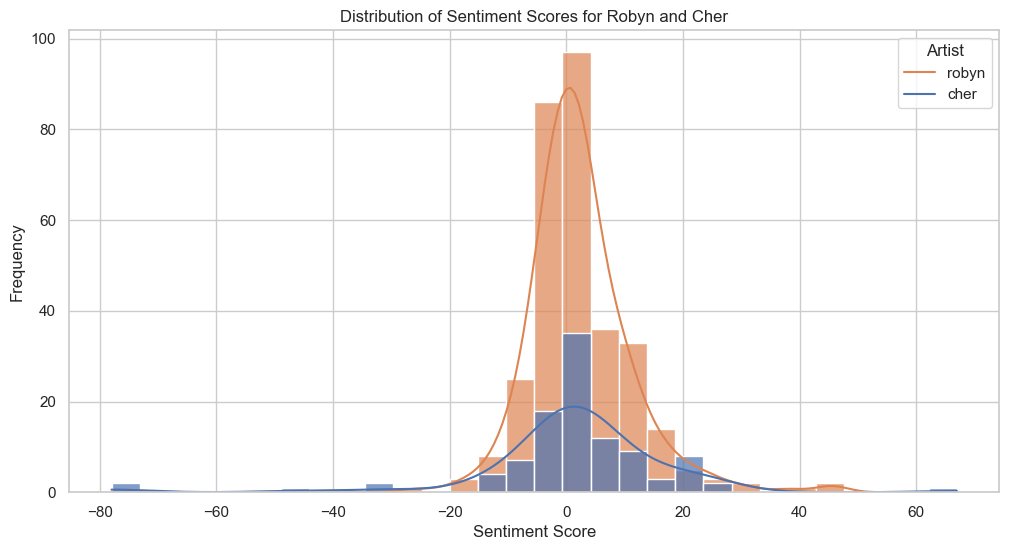

In [86]:

sns.set(style="whitegrid")

# Plot the distributions of sentiment scores for both artists
plt.figure(figsize=(12, 6))
sns.histplot(data=sentiment_df, x='sentiment', hue='artist', kde=True, bins=30, alpha=0.7)

# Set legend labels
legend_labels = sentiment_df['artist'].unique()

# Set plot labels and title
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores for Robyn and Cher')

# Show the legend with manual labels
plt.legend(title='Artist', labels=legend_labels)

# Show the plot
plt.show()

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. You do not need to calculate sentiment on non-emoji content for this section.

In [87]:
# your code here
# Define positive and negative emojis with associated scores
positive_emojis = ['😊', '😍', '🌟', '👍', '🎉', '💖', '😄', '🥳', '👏', '🙌']
negative_emojis = ['😢', '😠', '😔', '👎', '😞', '😕', '😒', '😑', '🙁', '😩']

# Create a function to calculate sentiment score based on emojis
def calculate_emoji_sentiment(description):
    sentiment_score = 0
    for emoji in description:
        if emoji in positive_emojis:
            sentiment_score += 1
        elif emoji in negative_emojis:
            sentiment_score -= 1
    return sentiment_score

In [88]:
artist_sentiments = []

# Iterate over the twitter_data list
for artist_entry in twitter_data:
    artist_name = artist_entry['artist']
    descriptions = artist_entry['descriptions']

    # Calculate sentiment score for each description based on emojis
    sentiment_scores = [calculate_emoji_sentiment(description) 
                        for description in descriptions]

    # Calculate average sentiment score for the artist
    average_sentiment = sum(sentiment_scores) / len(sentiment_scores)

    artist_sentiments.append({'artist': artist_name, 
                              'average_sentiment': average_sentiment})

# Print the results
for sentiment_entry in artist_sentiments:
    artist_name = sentiment_entry['artist']
    average_sentiment = sentiment_entry['average_sentiment']

    print(f"Average sentiment for {artist_name}: {average_sentiment}")

Average sentiment for cher: 0.007686736993038205
Average sentiment for robynkonichiwa: 0.003990267096759792


In [101]:
import emoji

cher_positive_emoji_frequency = {}

# Iterate over the twitter_data list
for artist_entry in twitter_data:
    artist_name = artist_entry['artist']
    descriptions = artist_entry['descriptions']

    # Check if the artist is Cher
    if artist_name == 'cher':
        # Count the frequency of each positive emoji in Cher's descriptions
        for description in descriptions:
            for emoji in description:
                if emoji in positive_emojis:
                    cher_positive_emoji_frequency[emoji] = 
                    cher_positive_emoji_frequency.get
                    (emoji, 0) + 1

# Find Cher's most popular positive emoji
cher_most_popular_positive_emoji = max(cher_positive_emoji_frequency, 
                                       key=cher_positive_emoji_frequency.get)

# Print the result with the actual emoji
cher_most_popular_positive_emoji_display = 
cher_most_popular_positive_emoji.encode('utf-16','surrogatepass').decode('utf-16')

print(f"Cher's most popular positive emoji is '{cher_most_popular_positive_emoji_display}
' with a frequency of {cher_positive_emoji_frequency[cher_most_popular_positive_emoji]}.")

Cher's most popular positive emoji is '💖' with a frequency of 8926.


In [102]:
cher_negative_emoji_frequency = {}

# Iterate over the twitter_data list
for artist_entry in twitter_data:
    artist_name = artist_entry['artist']
    descriptions = artist_entry['descriptions']

    # Check if the artist is Cher
    if artist_name == 'cher':
        # Count the frequency of each negative emoji in Cher's descriptions
        for description in descriptions:
            for emoji in description:
                if emoji in negative_emojis:
                    cher_negative_emoji_frequency[emoji] = 
                    cher_negative_emoji_frequency.get(emoji, 0) + 1

# Find Cher's most negative emoji
cher_most_negative_emoji = max(cher_negative_emoji_frequency, 
                               key=cher_negative_emoji_frequency.get)

# Print the result with the actual emoji
cher_most_negative_emoji_display = cher_most_negative_emoji.encode
('utf-16', 'surrogatepass').decode('utf-16')

print(f"Cher's most negative emoji is '{cher_most_negative_emoji_display}
' with a frequency of {cher_negative_emoji_frequency[cher_most_negative_emoji]}.")

Cher's most negative emoji is '😔' with a frequency of 387.


In [104]:
robyn_positive_emoji_frequency = {}

# Iterate over the twitter_data list
for artist_entry in twitter_data:
    artist_name = artist_entry['artist']
    descriptions = artist_entry['descriptions']

    # Check if the artist is Robyn
    if artist_name == 'robynkonichiwa':
        # Count the frequency of each positive emoji in Robyn's descriptions
        for description in descriptions:
            for emoji in description:
                if emoji in positive_emojis:
                    robyn_positive_emoji_frequency[emoji] = 
                    robyn_positive_emoji_frequency.get(emoji, 0) + 1

# Find Robyn's most popular positive emoji
robyn_most_popular_positive_emoji = max(robyn_positive_emoji_frequency, 
                                        key=robyn_positive_emoji_frequency.get)

# Print the result with the actual emoji
robyn_most_popular_positive_emoji_display = robyn_most_popular_positive_emoji.encode
('utf-16', 'surrogatepass').decode('utf-16')

print(f"Robyn's most popular positive emoji is '{robyn_most_popular_positive_emoji_display}
' with a frequency of {robyn_positive_emoji_frequency[robyn_most_popular_positive_emoji]}.")

Robyn's most popular positive emoji is '💖' with a frequency of 413.


In [105]:
robyn_negative_emoji_frequency = {}

# Iterate over the twitter_data list
for artist_entry in twitter_data:
    artist_name = artist_entry['artist']
    descriptions = artist_entry['descriptions']

    # Check if the artist is Robyn
    if artist_name == 'robynkonichiwa':
        # Count the frequency of each negative emoji in Robyn's descriptions
        for description in descriptions:
            for emoji in description:
                if emoji in negative_emojis:
                    robyn_negative_emoji_frequency[emoji] = 
                    robyn_negative_emoji_frequency.get(emoji, 0) + 1

# Find Robyn's most negative emoji
robyn_most_negative_emoji = max(robyn_negative_emoji_frequency, 
                                key=robyn_negative_emoji_frequency.get)

# Print the result with the actual emoji
robyn_most_negative_emoji_display = robyn_most_negative_emoji.encode
('utf-16', 'surrogatepass').decode('utf-16')

print(f"Robyn's most negative emoji is '{robyn_most_negative_emoji_display}
' with a frequency of {robyn_negative_emoji_frequency[robyn_most_negative_emoji]}.")

Robyn's most negative emoji is '😒' with a frequency of 15.


Q: What is the average sentiment of your two artists? 

A: 

Average sentiment for cher: 0.007686736993038205

Average sentiment for robynkonichiwa: 0.003990267096759792

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: 

Cher's most popular positive emoji is '💖' with a frequency of 8926.

Cher's most negative emoji is '😔' with a frequency of 387.

Robyn's most popular positive emoji is '💖' with a frequency of 413.

Robyn's most negative emoji is '😒' with a frequency of 15.
